In [ ]:
pip install diffusers transformers accelerate torch torchvision datasets


In [ ]:
import os

folders = [
    "data/clean",
    "data/degraded",
    "outputs"
    "scripts",
    "scripts",
    "utils"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Directory structure created.")


Directory structure created.


In [ ]:
!pip install python-docx


In [ ]:
from PIL import ImageFont

FONT_PATH = "/content/IMFellEnglishSC-Regular.ttf"  # match the uploaded file name
font = ImageFont.truetype(FONT_PATH, 24)



In [ ]:
!ls -l *.ttf


-rw-r--r-- 1 root root 180328 Apr  8 14:22 IMFellEnglishSC-Regular.ttf


In [ ]:
!pip install torch pillow tqdm


In [ ]:
dataset_code = """
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as transforms

class DegradedTextDataset(Dataset):
    def __init__(self, degraded_dir, clean_dir, image_size=128):
        self.degraded_paths = sorted([
            os.path.join(degraded_dir, f)
            for f in os.listdir(degraded_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.clean_paths = sorted([
            os.path.join(clean_dir, f)
            for f in os.listdir(clean_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return min(len(self.degraded_paths), len(self.clean_paths))

    def __getitem__(self, idx):
        degraded = Image.open(self.degraded_paths[idx])
        clean = Image.open(self.clean_paths[idx])

        return self.transform(degraded), self.transform(clean)
"""

with open("scripts/dataset.py", "w") as f:
    f.write(dataset_code.strip())


In [ ]:
unet_code = """
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.encoder = nn.Sequential(
            CBR(in_channels, 64),
            CBR(64, 128),
            nn.MaxPool2d(2)
        )
        self.middle = CBR(128, 128)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            CBR(128, 64),
            nn.Conv2d(64, out_channels, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x
"""

with open("scripts/unet.py", "w") as f:
    f.write(unet_code.strip())


🌟 Epoch 1/3


 33%|███▎      | 1/3 [00:02<00:04,  2.26s/it]

[Step 0] Loss: 1.1041


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


📉 Avg Epoch Loss: 1.0108
🌟 Epoch 2/3


 33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]

[Step 0] Loss: 0.8836


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


📉 Avg Epoch Loss: 0.8670
🌟 Epoch 3/3


 33%|███▎      | 1/3 [00:02<00:04,  2.15s/it]

[Step 0] Loss: 0.8085


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


📉 Avg Epoch Loss: 0.7505
 Model saved at checkpoints/final_model.pth


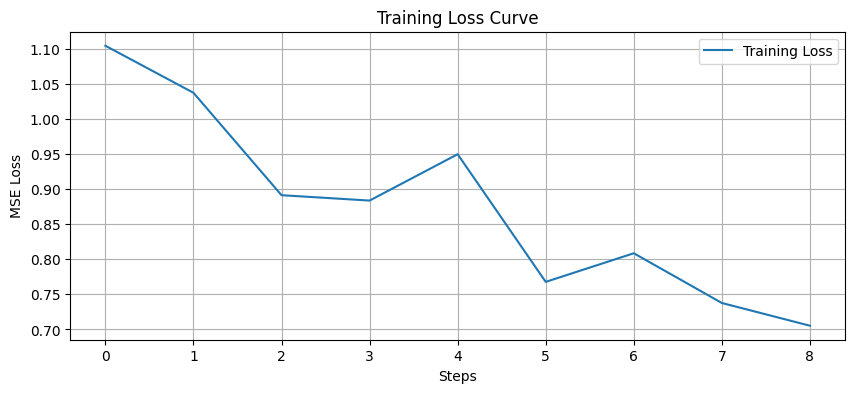

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from scripts.dataset import DegradedTextDataset
from scripts.unet import UNet
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ============ Config ============
BATCH_SIZE = 4
EPOCHS = 3
IMAGE_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============ Load Dataset ============
dataset = DegradedTextDataset(
    degraded_dir="data/degraded",
    clean_dir="data/clean",
    image_size=IMAGE_SIZE
)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ============ Linear Beta Schedule ============
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_hat = torch.cumprod(alphas, dim=0)

# ============ Noise Addition ============
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_hat = alphas_hat[t][:, None, None, None].sqrt().to(DEVICE)
    sqrt_one_minus = (1 - alphas_hat[t])[:, None, None, None].sqrt().to(DEVICE)
    x_t = sqrt_alpha_hat * x0 + sqrt_one_minus * noise
    return x_t, noise

# ============ Initialize Model ============
model = UNet(in_channels=1, out_channels=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()
all_losses = []

# ============ Training ============
for epoch in range(EPOCHS):
    print(f"🌟 Epoch {epoch + 1}/{EPOCHS}")
    epoch_loss = 0.0
    for i, (degraded, clean) in enumerate(tqdm(loader)):
        degraded, clean = degraded.to(DEVICE), clean.to(DEVICE)
        t = torch.randint(0, T, (degraded.size(0),)).long().to(DEVICE)

        #Inverted DDPM: Add noise to clean target
        x_t, noise = add_noise(clean, t)
        predicted_noise = model(x_t)
        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        all_losses.append(loss.item())

        if i % 10 == 0:
            print(f"[Step {i}] Loss: {loss.item():.4f}")
            save_image(x_t[0], f"{SAVE_DIR}/noisy_{epoch}_{i}.png")
            save_image(predicted_noise[0], f"{SAVE_DIR}/pred_noise_{epoch}_{i}.png")

    avg_epoch_loss = epoch_loss / len(loader)
    print(f"📉 Avg Epoch Loss: {avg_epoch_loss:.4f}")

# ============ Save Model ============
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/final_model.pth")
print(" Model saved at checkpoints/final_model.pth")

# ============ Plot Loss ============
plt.figure(figsize=(10, 4))
plt.plot(all_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig(f"{SAVE_DIR}/loss_curve.png")
plt.show()


[0] Output min: 0.0098, max: 0.1587


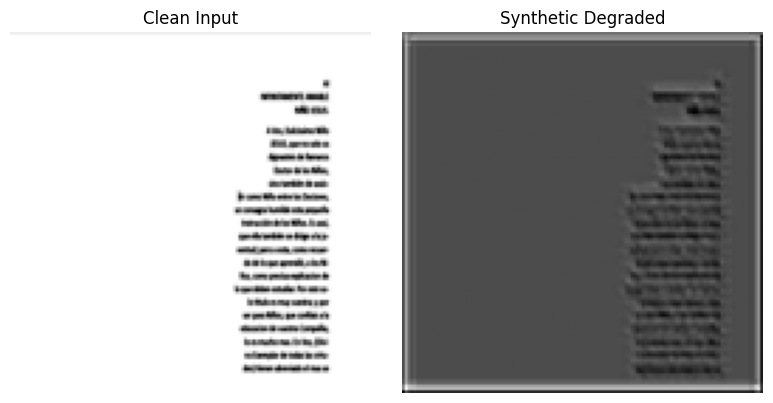

[1] Output min: 0.0138, max: 0.1577


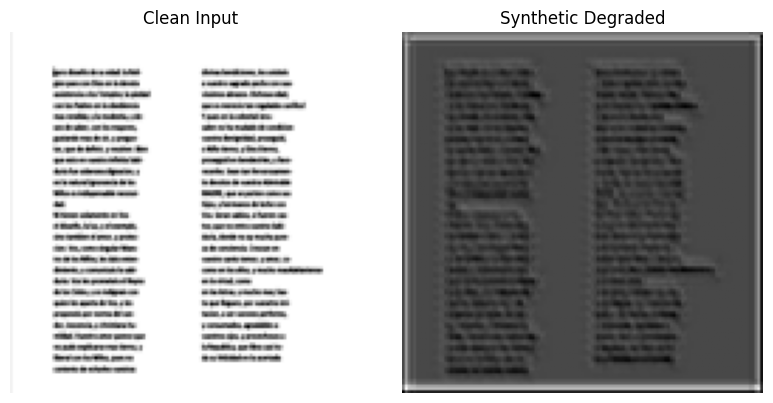

[2] Output min: 0.0162, max: 0.1587


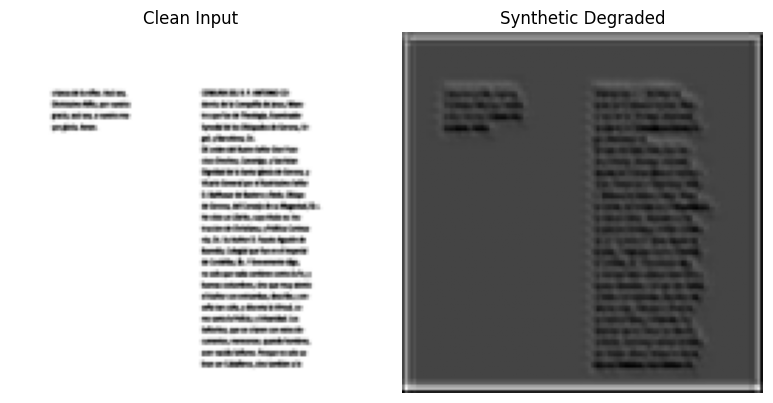

[3] Output min: -0.0051, max: 0.1569


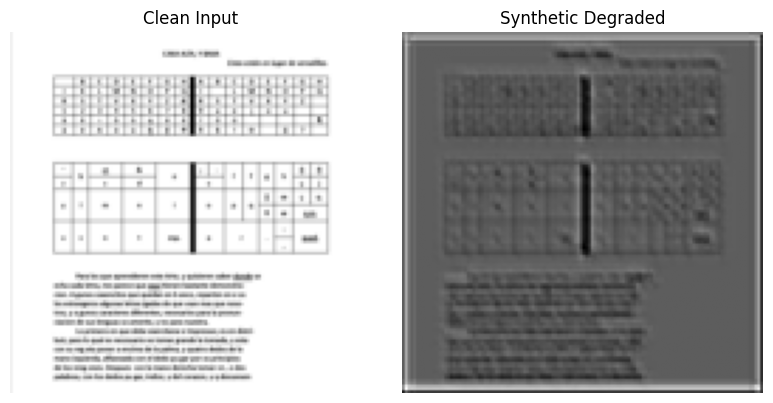

[4] Output min: 0.0157, max: 0.1587


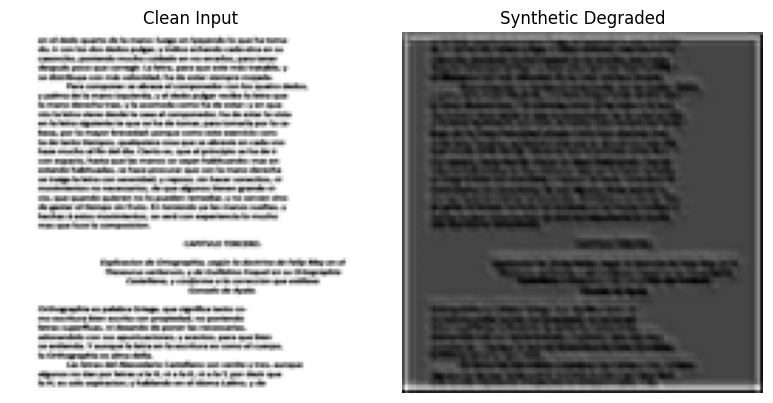

[5] Output min: 0.0104, max: 0.1587


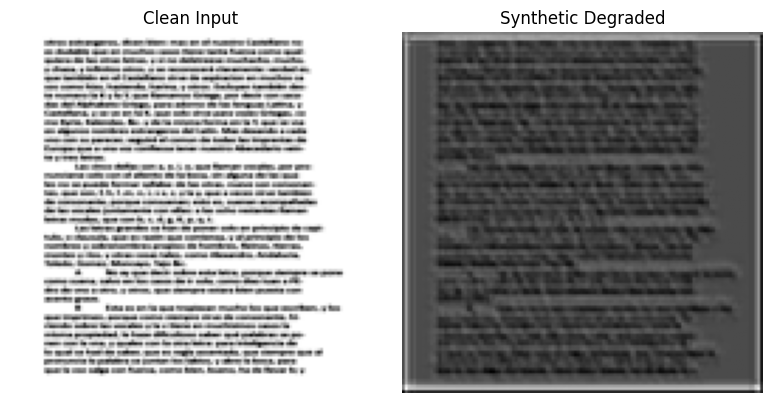

[6] Output min: 0.0173, max: 0.1587


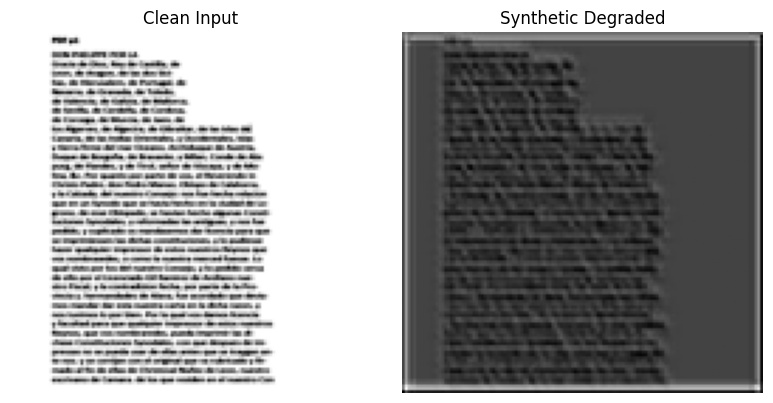

[7] Output min: -0.0116, max: 0.1587


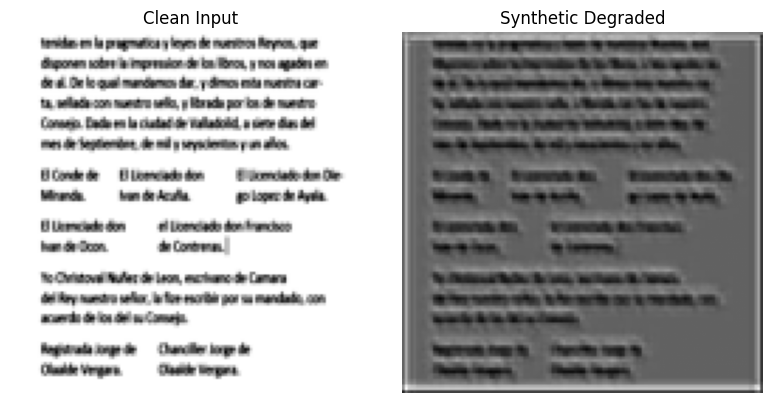

[8] Output min: 0.0173, max: 0.1587


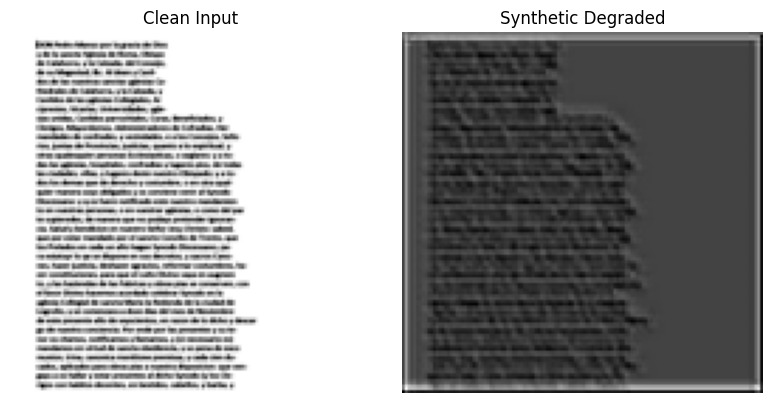

In [40]:
import torch
from torchvision.utils import save_image
from scripts.dataset import DegradedTextDataset
from scripts.unet import UNet
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clean_dir = "/content/data/clean"
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# === Load model ===
model = UNet()
model.load_state_dict(torch.load("checkpoints/final_model.pth", map_location=device))
model.to(device)
model.eval()

# === Load clean images ===
dataset = DegradedTextDataset(clean_dir, clean_dir)  # Only using clean_dir as input
loader = DataLoader(dataset, batch_size=1, shuffle=False)


def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    if max_val - min_val > 1e-5:
        return (tensor - min_val) / (max_val - min_val)
    else:
        return tensor  # Avoid division by zero

# === Inference + Visualization ===
with torch.no_grad():
    for i, (clean, _) in enumerate(loader):
        clean = clean.to(device)
        output = model(clean)

        # Debug output values
        print(f"[{i}] Output min: {output.min().item():.4f}, max: {output.max().item():.4f}")

        # Normalize before saving
        output_norm = normalize_tensor(output)

        # Save
        pil_img = to_pil_image(output_norm.squeeze(0).cpu())
        pil_img.save(f"{output_dir}/synthetic_{i:03d}.png")

        # Show side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(to_pil_image(clean.squeeze(0).cpu()), cmap='gray')
        axes[0].set_title("Clean Input")
        axes[0].axis("off")

        axes[1].imshow(pil_img, cmap='gray')
        axes[1].set_title("Synthetic Degraded")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()
